### Q1: Write the code for downloading and formatting the data.

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [110]:
train_data_raw = datasets.MNIST(root='./data', train=True, download=True)
test_data_raw = datasets.MNIST(root='./data', train=False, download=True)

train_data = []
for i in range(len(train_data_raw)):
    x = np.array(train_data_raw.data[i]).flatten() / 255.0
    y = np.zeros(10)
    y[train_data_raw.targets[i]] = 1
    train_data.append((x, y))

test_data = []
for i in range(len(test_data_raw)):
    x = np.array(test_data_raw.data[i]).flatten() / 255.0
    y = np.zeros(10)
    y[test_data_raw.targets[i]] = 1
    test_data.append((x, y))

#### SGD Implementation

In [166]:
norm_factor = 1e-3

def SGD(ITR, B, lr, data, eval_data = True):
    W = np.zeros((784, 10))
    N = len(data)

    x_vals = []
    loss_vals = []
    acc_vals = []
    for i in range(ITR):
        random_items = np.random.choice(N, size=B, replace=True)
        X = np.vstack([data[j][0] for j in random_items])
        y = np.vstack([data[j][1] for j in random_items])

        loss_grad = X.T @ (X @ W - y)
        grad = (1.0 / B) * loss_grad + norm_factor * W
        W = W - lr * grad

        if eval_data and i % (ITR // 100) == 0: # only record 100 points or else graph is too dense
            X_test = np.vstack([test_data[j][0] for j in range(len(test_data))])
            y_test = np.vstack([test_data[j][1] for j in range(len(test_data))])

            x_vals.append(i)
            loss = np.mean(np.sum((X_test @ W - y_test) ** 2, axis=1))
            loss_vals.append(loss)
            acc = np.mean(np.argmax(X_test @ W, axis=1) == np.argmax(y_test, axis=1)) * 100
            acc_vals.append(acc)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(x_vals, loss_vals)
    ax[0].set_title("Loss")
    ax[1].plot(x_vals, acc_vals)
    ax[1].set_title("Accuracy")
    plt.show()

    return W, acc_vals[-1]

#### The role of batch size

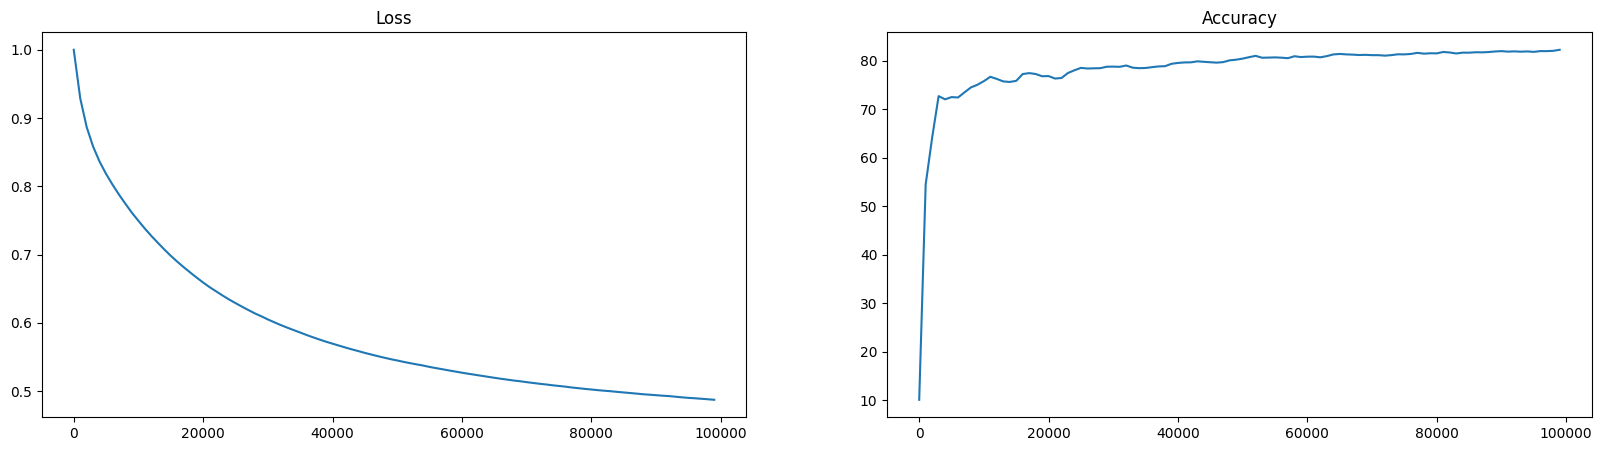

In [156]:
ITR = 100000
B = 1
lr = 1e-5

W = SGD(ITR, B, lr, train_data)

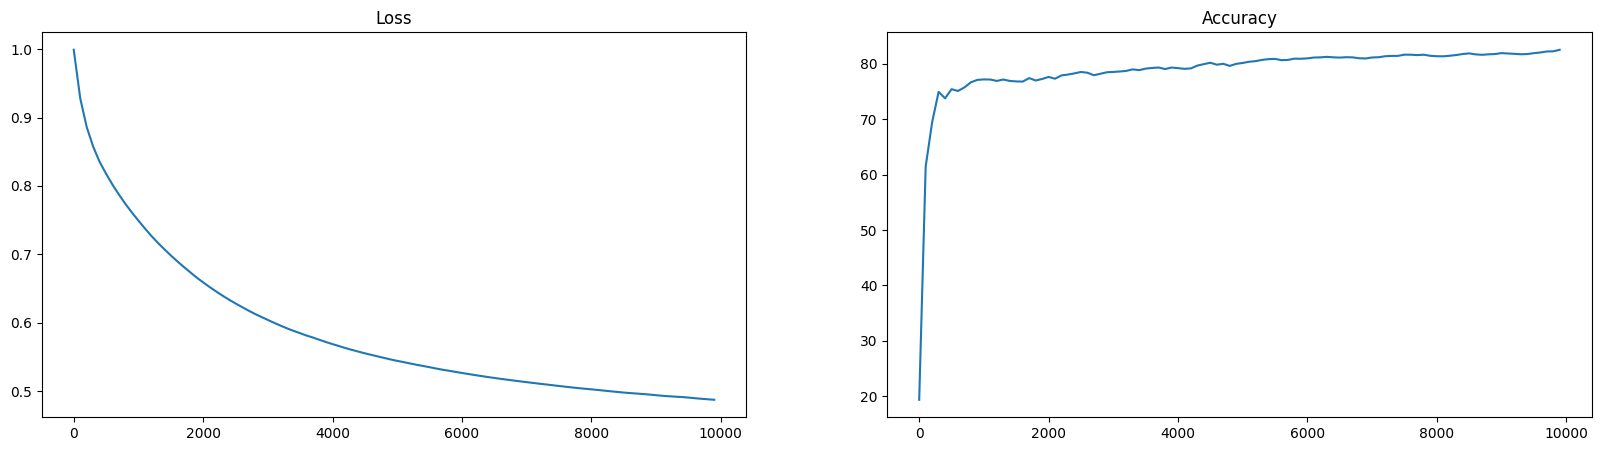

In [164]:
ITR = 10000
B = 10
lr = 1e-4

W = SGD(ITR, B, lr, train_data, eval_data=True)

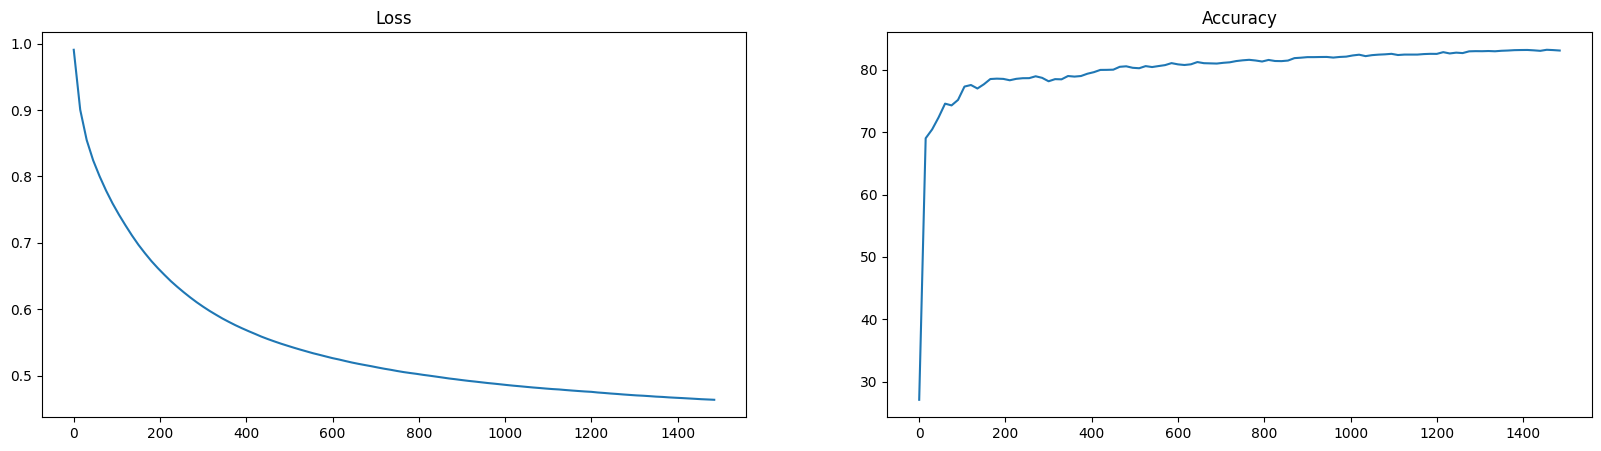

In [157]:
ITR = 1500
B = 100
lr = 1e-3

W = SGD(ITR, B, lr, train_data)

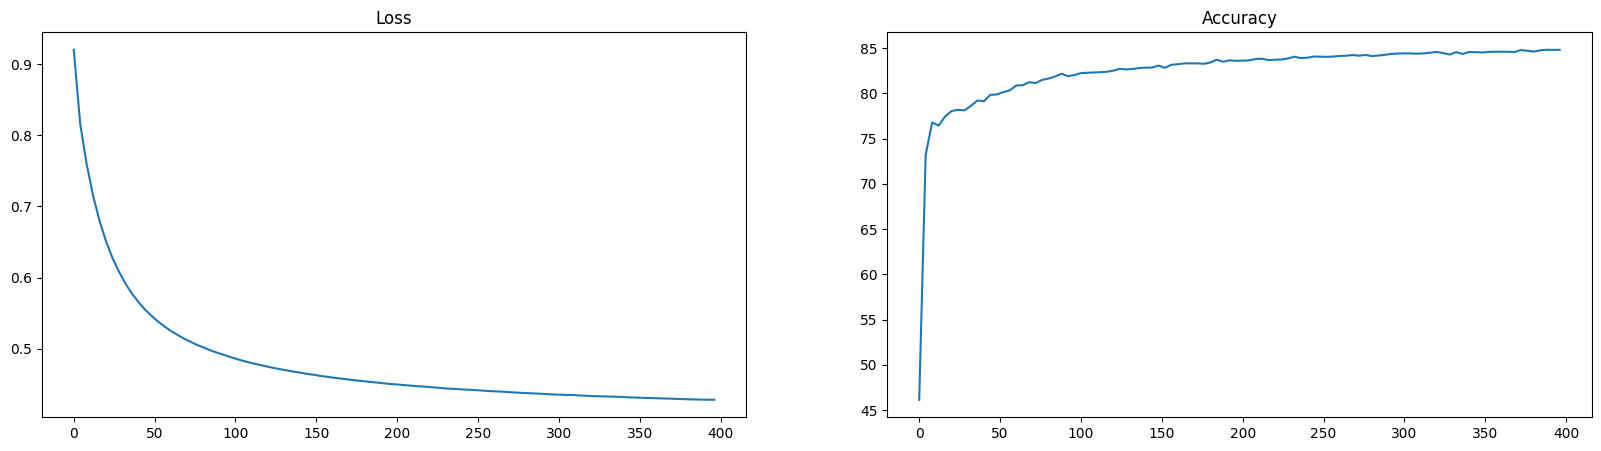

In [160]:
ITR = 400
B = 1000
lr = 1e-2

W = SGD(ITR, B, lr, train_data)

#### The role of training dataset size

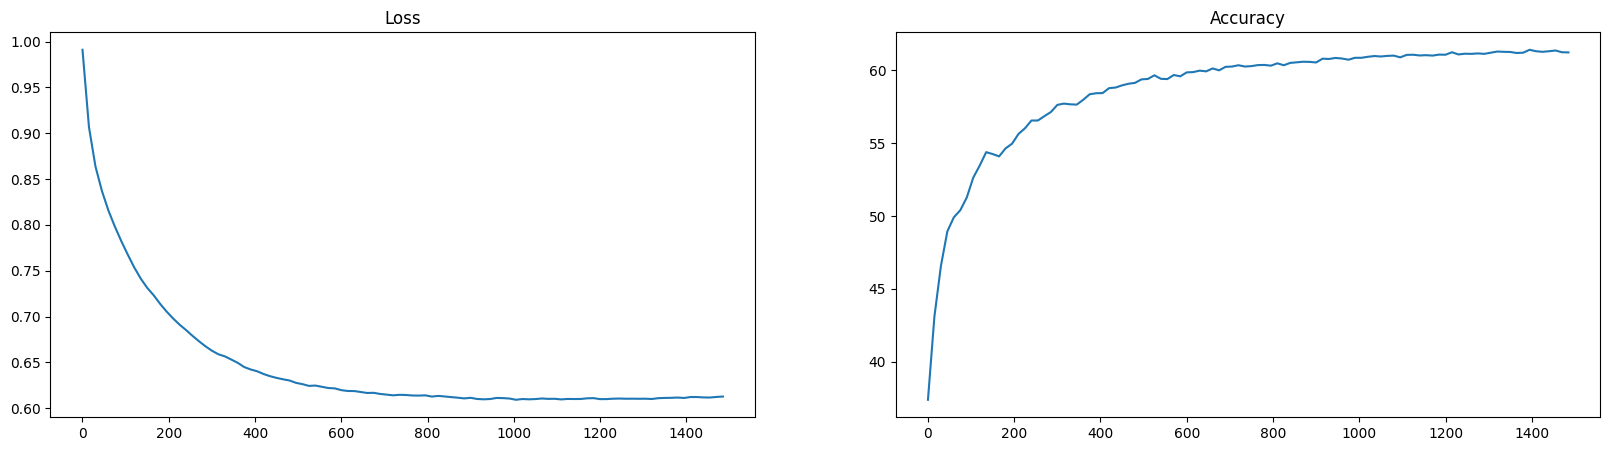

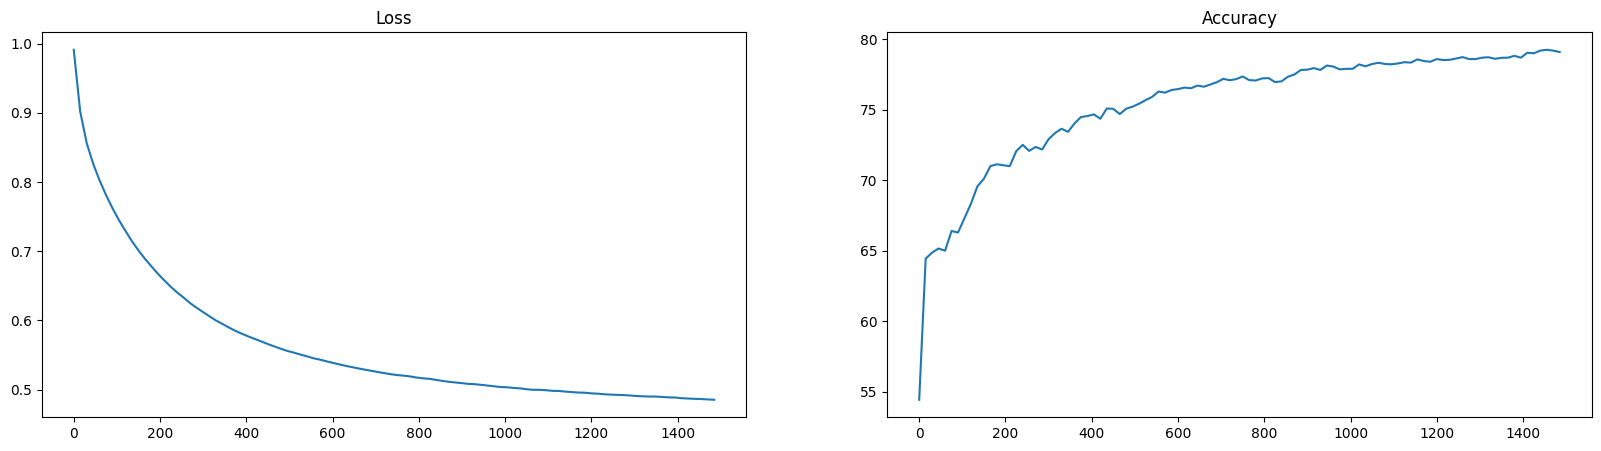

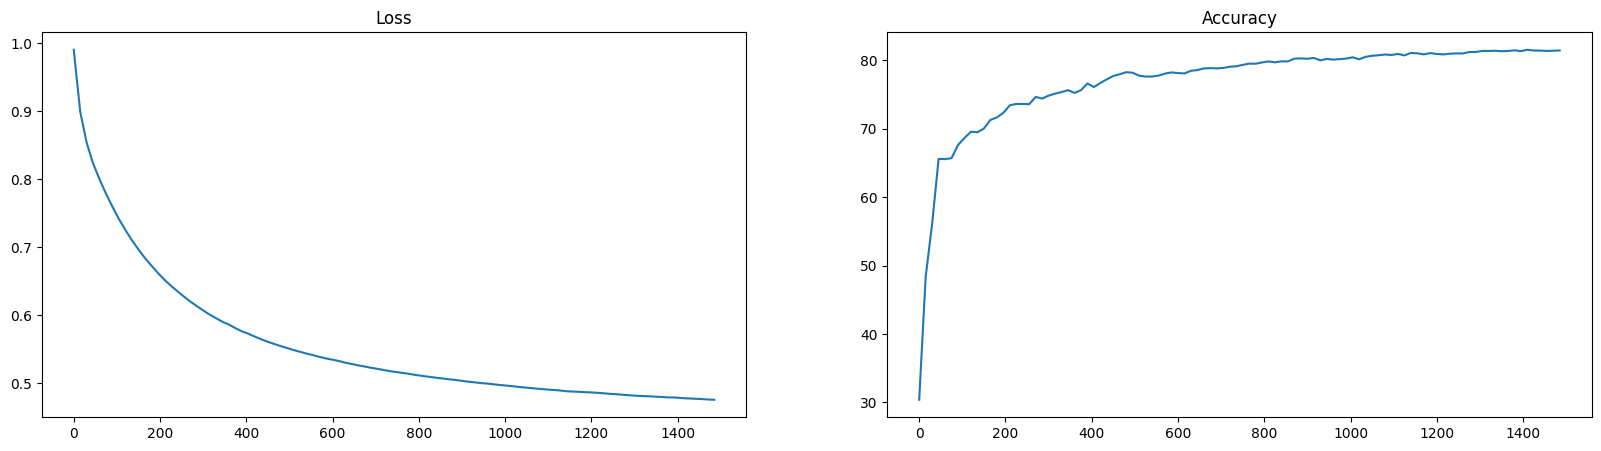

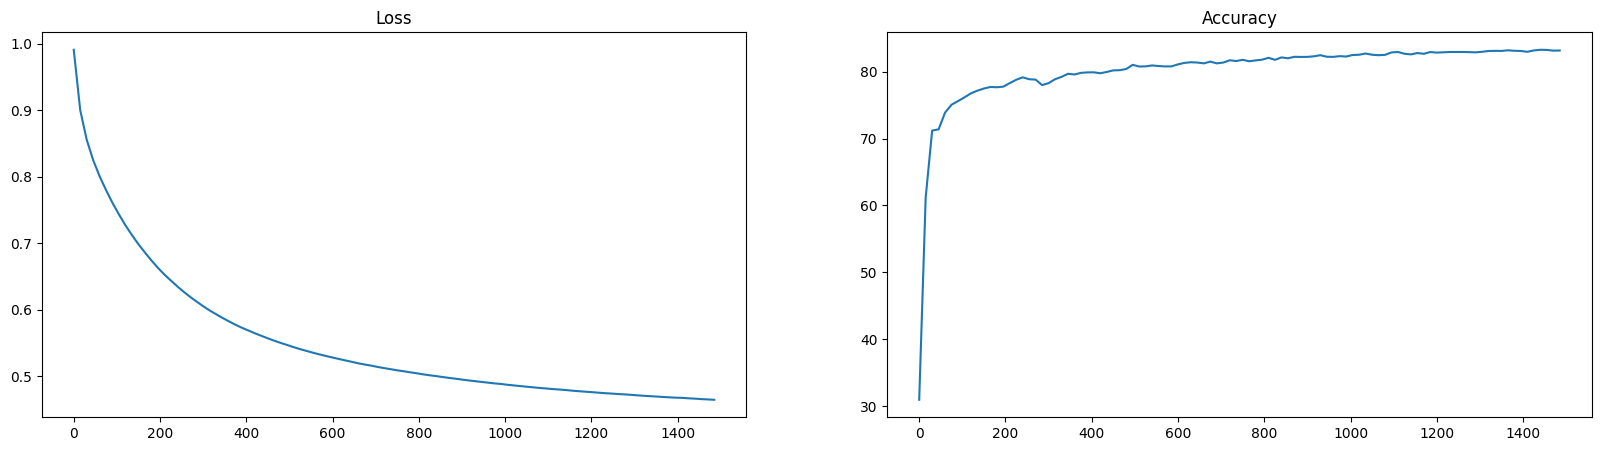

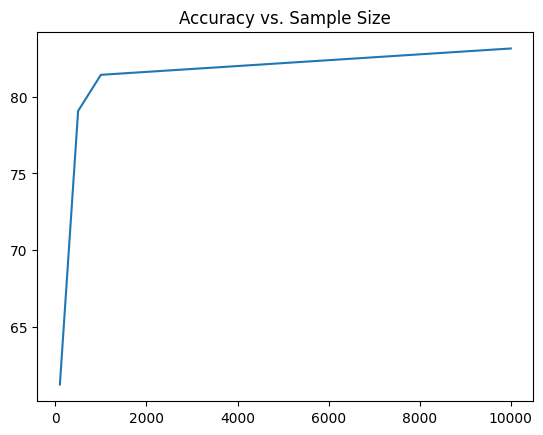

In [167]:
ITR = 1500
B = 100
lr = 1e-3

s_sizes = [100, 500, 1000, 10000]
accs = []

for N_ in s_sizes:
    s = np.random.choice(len(train_data), size=N_, replace=True)
    S_ = [train_data[i] for i in s]

    W, acc = SGD(ITR, B, lr, S_)
    accs.append(acc)

plt.plot(s_sizes, accs)
plt.title("Accuracy vs. Sample Size")
plt.show()

#### With PyTorch

In [136]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(784, 10)
        self._initialize_weights()
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def _initialize_weights(self):
        self.fc.weight.data.fill_(0.0)
        self.fc.bias.data.fill_(0.0)

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

B = 100
lr = 1e-3

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=B)
test_loader = DataLoader(dataset=test_dataset, batch_size=B)

Epoch [1/20], Loss: 2.0264
Test Loss: 1.7783, Test Accuracy: 76.52%
Epoch [2/20], Loss: 1.6132
Test Loss: 1.4449, Test Accuracy: 79.86%
Epoch [3/20], Loss: 1.3478
Test Loss: 1.2282, Test Accuracy: 81.59%
Epoch [4/20], Loss: 1.1716
Test Loss: 1.0810, Test Accuracy: 82.51%
Epoch [5/20], Loss: 1.0489
Test Loss: 0.9760, Test Accuracy: 83.39%
Epoch [6/20], Loss: 0.9591
Test Loss: 0.8977, Test Accuracy: 83.92%
Epoch [7/20], Loss: 0.8908
Test Loss: 0.8371, Test Accuracy: 84.43%
Epoch [8/20], Loss: 0.8370
Test Loss: 0.7888, Test Accuracy: 84.94%
Epoch [9/20], Loss: 0.7935
Test Loss: 0.7493, Test Accuracy: 85.33%
Epoch [10/20], Loss: 0.7575
Test Loss: 0.7164, Test Accuracy: 85.63%
Epoch [11/20], Loss: 0.7273
Test Loss: 0.6885, Test Accuracy: 85.96%
Epoch [12/20], Loss: 0.7014
Test Loss: 0.6645, Test Accuracy: 86.26%
Epoch [13/20], Loss: 0.6790
Test Loss: 0.6436, Test Accuracy: 86.40%
Epoch [14/20], Loss: 0.6593
Test Loss: 0.6253, Test Accuracy: 86.61%
Epoch [15/20], Loss: 0.6420
Test Loss: 0.60

Text(0.5, 1.0, 'Accuracy')

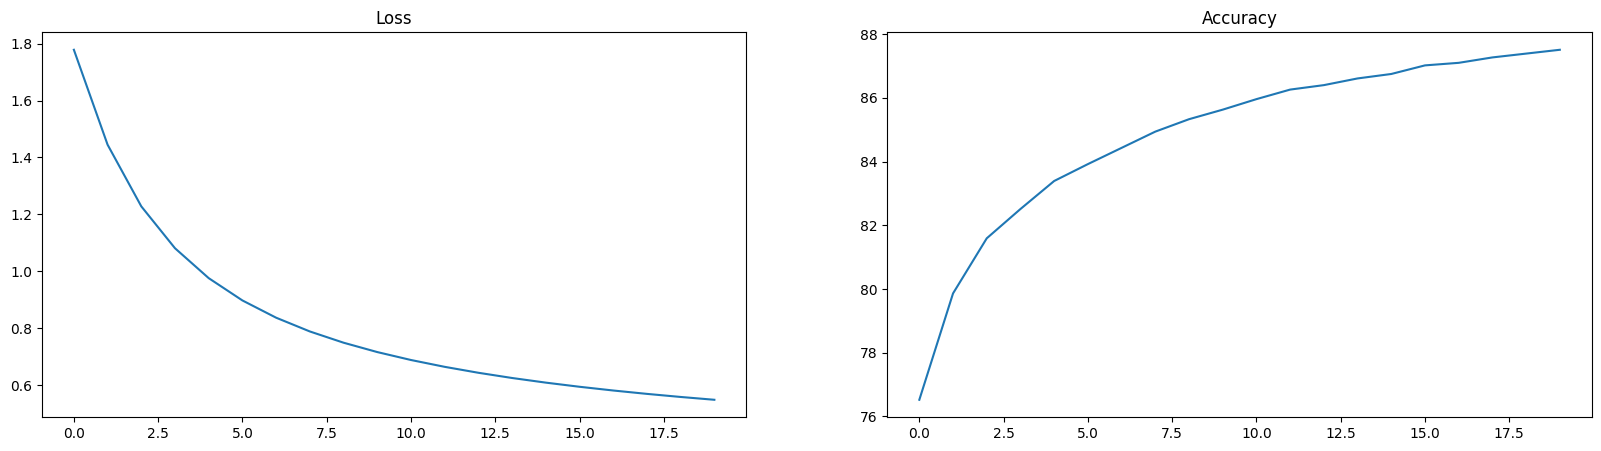

In [149]:
model = Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_vals = []
acc_vals = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            outputs_test = model(X_test)
            loss = criterion(outputs_test, y_test)
            test_loss += loss.item()

            _, predicted = torch.max(outputs_test.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    loss_vals.append(avg_test_loss)
    acc_vals.append(accuracy)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(loss_vals)
ax[0].set_title("Loss")
ax[1].plot(acc_vals)
ax[1].set_title("Accuracy")